SMOTE is available.
Missing values:
 month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
dayfri           0
daymon           0
daysat           0
daysun           0
daythu           0
daytue           0
daywed           0
monthapr         0
monthaug         0
monthdec         0
monthfeb         0
monthjan         0
monthjul         0
monthjun         0
monthmar         0
monthmay         0
monthnov         0
monthoct         0
monthsep         0
size_category    0
dtype: int64

Value Counts of Target (size_category):
 size_category
small    378
large    139
Name: count, dtype: int64
Train rows: 413, Test rows: 104
Applied SMOTE to balance classes.

Default SVM Accuracy: 0.5865384615384616

Default SVM Classification Report:
               precision    recall  f1-score   support

       small       0.71      0.74      0.72        76

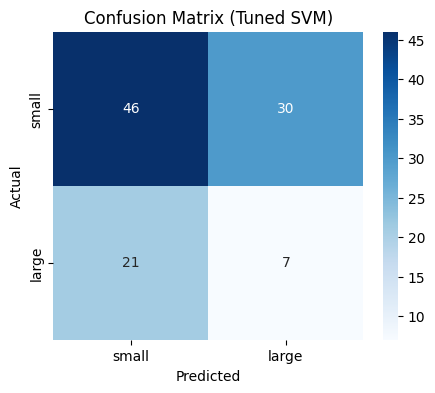

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Check for imblearn availability
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
    print("SMOTE is available.")
except ImportError:
    smote_available = False
    print("SMOTE (imblearn) is not installed. Proceeding without SMOTE. Install with: pip install imbalanced-learn")

# Load data
data = pd.read_csv('forestfires.csv')

# Check missing values and class distribution
print("Missing values:\n", data.isnull().sum())
print("\nValue Counts of Target (size_category):\n", data['size_category'].value_counts())

# Drop 'area', 'month', and 'day' to avoid leakage and string issues
data = data.drop(['area', 'month', 'day'], axis=1)

# Encode target variable (small=0, large=1)
data['size_category'] = data['size_category'].map({'small': 0, 'large': 1})

# Define features (X) and target (y)
X = data.drop('size_category', axis=1)
y = data['size_category']

# Scale numerical features only
numerical_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train rows: {X_train.shape[0]}, Test rows: {X_test.shape[0]}")

# Apply SMOTE if available, else rely on class_weight
if smote_available:
    smote = SMOTE(random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train, y_train)
    print("Applied SMOTE to balance classes.")
else:
    X_train_scaled = X_train
    print("SMOTE skipped. Using class_weight='balanced' to handle imbalance.")

# Train SVM with default parameters
svm = SVC(kernel='rbf', random_state=42, class_weight='balanced')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test)

# Evaluate default model
print("\nDefault SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nDefault SVM Classification Report:\n", classification_report(y_test, y_pred, target_names=['small', 'large']))

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}
grid_svm = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5)
grid_svm.fit(X_train_scaled, y_train)
print("\nBest Parameters:", grid_svm.best_params_)

# Evaluate tuned model
best_model = grid_svm.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nTuned SVM Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nTuned SVM Classification Report:\n", classification_report(y_test, y_pred_best, target_names=['small', 'large']))

# Confusion matrix for tuned model
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['small', 'large'], yticklabels=['small', 'large'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned SVM)')
plt.show()

In [ ]:
//